In [ ]:
!pip install pyreadstat
!pip install scipy
!pip install stepmix

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pyreadstat
from stepmix.stepmix import StepMix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score, silhouette_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
import scipy.cluster.hierarchy as shc

In [3]:
df = pd.read_spss('5 Opšta - doktorat - klase k sf 42.sav')

In [4]:
# Define the variables
variables = ["Uvidi_planiranje_kontrola_sf42",
 "Altruizam_sf42",
 "Religioznost_sf42",
 "Privrzenost_partneru_sf42",
 "Kvalitet_odnosa_sa_roditeljima_sf42",
 "Kontakt_podrska_rodbina_sf42",
 "Kontakt_podrska_prijatelji_sf42"]

# Standardize the data
scaler = StandardScaler()
df[variables] = scaler.fit_transform(df[variables])

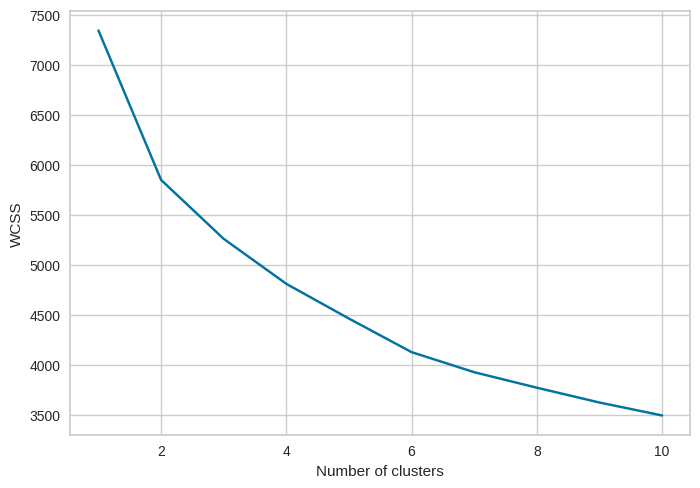

In [19]:
wcss = []
for i in range(1, 11):
   kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
   kmeans.fit(df[variables])
   wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# 2-cluster solution seems suitable

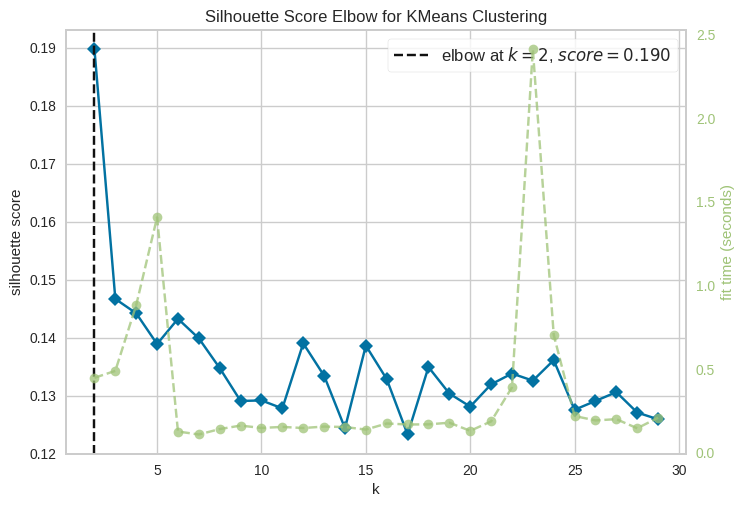

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [11]:
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True)
visualizer.fit(df[variables])
visualizer.show()

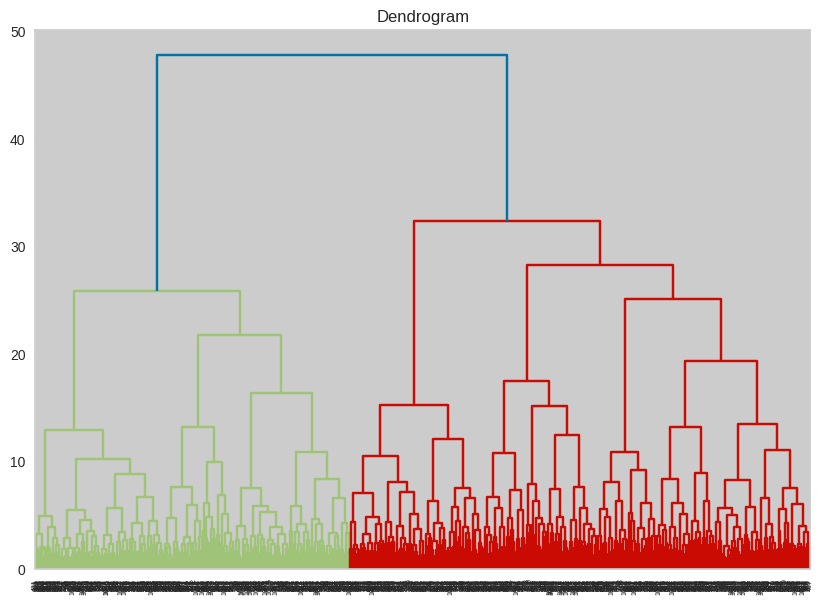

In [30]:
# Preliminary hierarchical clustering
clusters = shc.linkage(df[variables], method='ward', metric='euclidean')

plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
shc.dendrogram(clusters)
plt.show()

In [26]:
# Preliminary K-means cluster analysis

kmeans = KMeans(n_clusters=2, random_state=0)
df['kmeans_cluster'] = kmeans.fit_predict(df[variables])

silhouette_score_kmeans = metrics.silhouette_score(df[variables], df['kmeans_cluster'], metric='euclidean')
print('Silhouette Score (K-means):', silhouette_score_kmeans)
db_score_kmeans = davies_bouldin_score(df[variables], df['kmeans_cluster'])
print('Davies-Bouldin Index (K-means):', db_score_kmeans)
ch_score_kmeans = calinski_harabasz_score(df[variables], df['kmeans_cluster'])
print('Calinski-Harabasz Index (K-means):', ch_score_kmeans)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score (K-means): 0.13591662808845473
Davies-Bouldin Index (K-means): 1.8353969480336711
Calinski-Harabasz Index (K-means): 168.5191503363006


In [33]:
# K-means clustering with K-means++ initialization
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=0)
df['kmeans_cluster'] = kmeans.fit_predict(df[variables])

silhouette_score_kmeans = metrics.silhouette_score(df[variables], df['kmeans_cluster'], metric='euclidean')
print('Silhouette Score (K-means):', silhouette_score_kmeans)
db_score_kmeans = davies_bouldin_score(df[variables], df['kmeans_cluster'])
print('Davies-Bouldin Index (K-means):', db_score_kmeans)
ch_score_kmeans = calinski_harabasz_score(df[variables], df['kmeans_cluster'])
print('Calinski-Harabasz Index (K-means):', ch_score_kmeans)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score (K-means): 0.18960019618893412
Davies-Bouldin Index (K-means): 1.903978978640334
Calinski-Harabasz Index (K-means): 267.5269497485498


In [13]:
# 2-stage hierarchical + K-means cluster analysis using previously recorded centroids

n_clusters = 2
n_repetitions = 10
n_bootstrap_samples = 1000

kappa_coefficients = []

for _ in range(n_repetitions):
 df1, df2 = train_test_split(df, test_size=0.5, random_state=42)
 for _ in range(n_bootstrap_samples):
     # Draw a bootstrap sample with replacement
     df1_bootstrap = resample(df1, n_samples=len(df1), replace=True)
     df2_bootstrap = resample(df2, n_samples=len(df2), replace=True)

     # Ward's hierarchical cluster analysis
     hierarchical_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
     hierarchical_clusters1 = hierarchical_clustering.fit_predict(df1_bootstrap[variables])
     hierarchical_clusters2 = hierarchical_clustering.fit_predict(df2_bootstrap[variables])

     # Calculate the centroids of the clusters
     centroids1 = df1_bootstrap[variables].groupby(hierarchical_clusters1).mean()
     centroids2 = df2_bootstrap[variables].groupby(hierarchical_clusters2).mean()

     # K-means clustering using the centroids
     kmeans_clustering = KMeans(n_clusters=n_clusters, init=centroids1.to_numpy(), n_init=1)
     kmeans_clusters1 = kmeans_clustering.fit_predict(df1_bootstrap[variables])
     kmeans_clustering = KMeans(n_clusters=n_clusters, init=centroids2.to_numpy(), n_init=1)
     kmeans_clusters2 = kmeans_clustering.fit_predict(df2_bootstrap[variables])

     # sCohen's kappa coefficient
     kappa1 = cohen_kappa_score(hierarchical_clusters1, kmeans_clusters1)
     kappa2 = cohen_kappa_score(hierarchical_clusters2, kmeans_clusters2)
     kappa_coefficients.append((kappa1, kappa2))

average_kappa1, average_kappa2 = np.mean(kappa_coefficients, axis=0)

print('Average Kappa Coefficient for Subsample 1:', average_kappa1)
print('Average Kappa Coefficient for Subsample 2:', average_kappa2)

Average Kappa Coefficient for Subsample 1: 0.6287666053202
Average Kappa Coefficient for Subsample 2: 0.6393827594928646


In [22]:
# LCA model
model = StepMix(n_components=5, measurement="continuous", verbose=1, random_state=123)

model.fit(df[variables])

# Save class membership predictions to df
res = model.predict(df[variables])
print(res)

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  3.92it/s, max_LL=-7.89e+3, max_avg_LL=-7.52]

MODEL REPORT
    Measurement model parameters
          model_name                                      gaussian_diag                                
          class_no                                                    0       1       2       3       4
          param       variable                                                                         
          covariances Altruizam_sf42                             0.8998  0.8498  0.9471  0.6820  0.3789
                      Kontakt_podrska_prijatelji_sf42            0.5671  1.2912  0.8681  0.5278  0.7892
                      Kontakt_podrska_rodbina_sf42               0.3898  0.2120  0.9041  0.6680  0.7266
                      Kvalitet_odnosa_sa_roditeljima_sf42        0.6834  0.9245  0.0000  0.0764  0.8505
                      Privrzenost_partneru_sf42                  0.8363  0.8740  1.0822  0.8237  1.1869
                      Religioznost_sf42                          0.8273  0.8884  1.0572  0.8669  0.1930
                  